# Introduction to Convolutional Neural Networks (CNNs)
    
This notebook provides a comprehensive introduction to Convolutional Neural Networks (CNNs), their architecture, and implementation in PyTorch. We'll use the MNIST dataset as an example.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Create directories if they don't exist
os.makedirs('results/models', exist_ok=True)
os.makedirs('results/plots', exist_ok=True)

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Preprocessing
    
We'll use the MNIST dataset, which contains 28x28 grayscale images of handwritten digits (0-9).

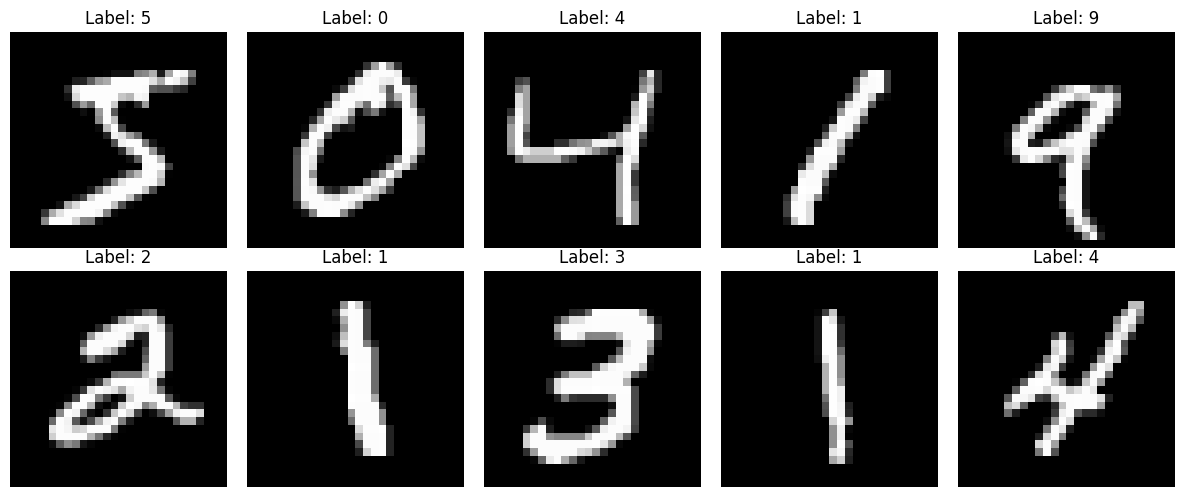

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Display some example images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('results/plots/mnist_examples.png')
plt.show()

## CNN Model Architecture
    
Let's define our CNN model with the following architecture:
1. Convolutional layer (1 → 16 channels)
2. ReLU activation and max pooling
3. Convolutional layer (16 → 32 channels)
4. ReLU activation and max pooling
5. Fully connected layers

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Model Training
    
We'll train the model using:
- Cross Entropy Loss
- Adam optimizer
- 5 epochs

In [4]:
def train_model(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Testing
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Save the model
    torch.save(model.state_dict(), 'results/models/mnist_cnn.pth')
    return train_losses, test_losses, train_accs, test_accs

# Train the model
train_losses, test_losses, train_accs, test_accs = train_model(model, train_loader, test_loader)

Epoch: 0, Batch: 0, Loss: 2.3124
Epoch: 0, Batch: 100, Loss: 0.2703
Epoch: 0, Batch: 200, Loss: 0.2125
Epoch: 0, Batch: 300, Loss: 0.1758
Epoch: 0, Batch: 400, Loss: 0.2910
Epoch: 0, Batch: 500, Loss: 0.1446
Epoch: 0, Batch: 600, Loss: 0.1445
Epoch: 0, Batch: 700, Loss: 0.0364
Epoch: 0, Batch: 800, Loss: 0.0395
Epoch: 0, Batch: 900, Loss: 0.0496
Epoch 1/5:
Train Loss: 0.1698, Train Acc: 94.98%
Test Loss: 0.0577, Test Acc: 98.13%
Epoch: 1, Batch: 0, Loss: 0.0392
Epoch: 1, Batch: 100, Loss: 0.0469
Epoch: 1, Batch: 200, Loss: 0.0414
Epoch: 1, Batch: 300, Loss: 0.0365
Epoch: 1, Batch: 400, Loss: 0.0142
Epoch: 1, Batch: 500, Loss: 0.0150
Epoch: 1, Batch: 600, Loss: 0.0634
Epoch: 1, Batch: 700, Loss: 0.0404
Epoch: 1, Batch: 800, Loss: 0.0672
Epoch: 1, Batch: 900, Loss: 0.0265
Epoch 2/5:
Train Loss: 0.0527, Train Acc: 98.36%
Test Loss: 0.0369, Test Acc: 98.78%
Epoch: 2, Batch: 0, Loss: 0.0410
Epoch: 2, Batch: 100, Loss: 0.0178
Epoch: 2, Batch: 200, Loss: 0.0359
Epoch: 2, Batch: 300, Loss: 0.0

## Results Visualization
    
Let's visualize the training results and model predictions.

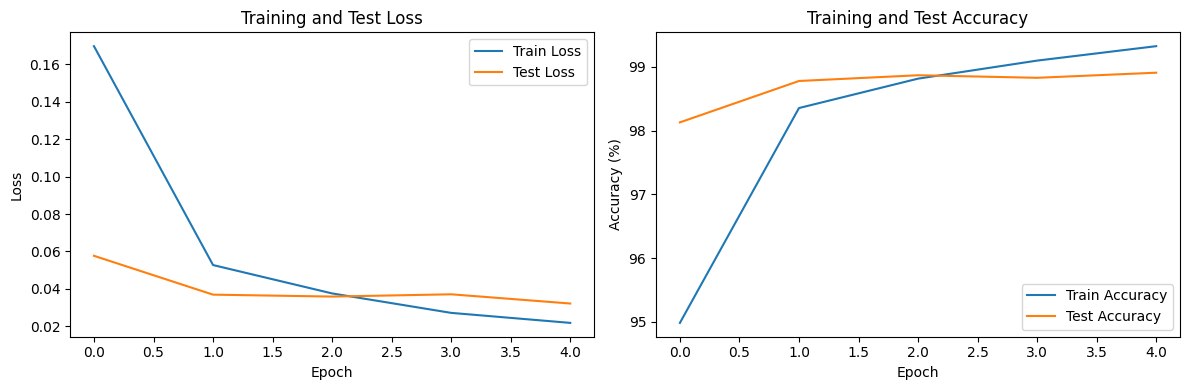

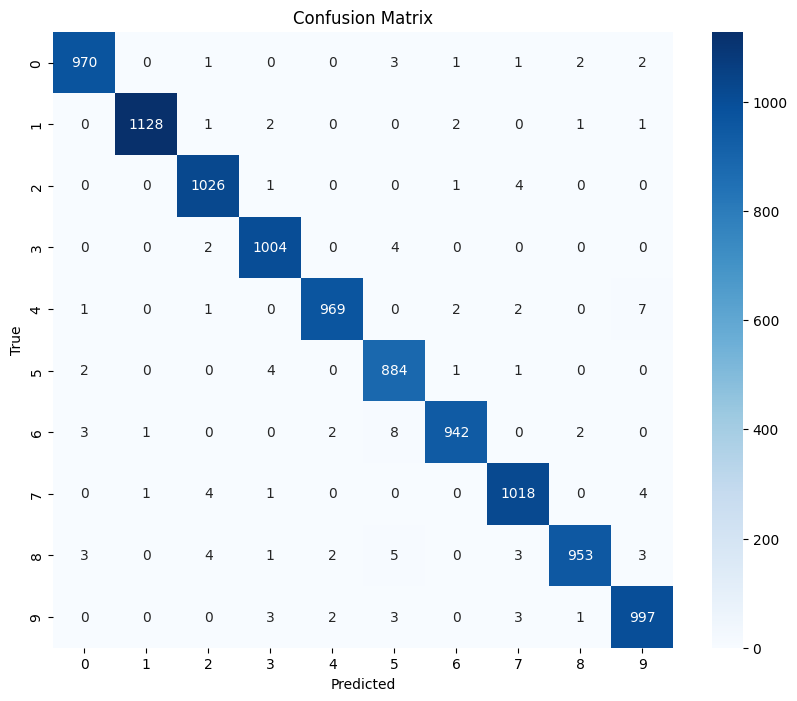

In [5]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.tight_layout()
plt.savefig('results/plots/training_history.png')
plt.show()

# Generate confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('results/plots/confusion_matrix.png')
plt.show()

## Model Inference
    
Let's test our model on some example images.

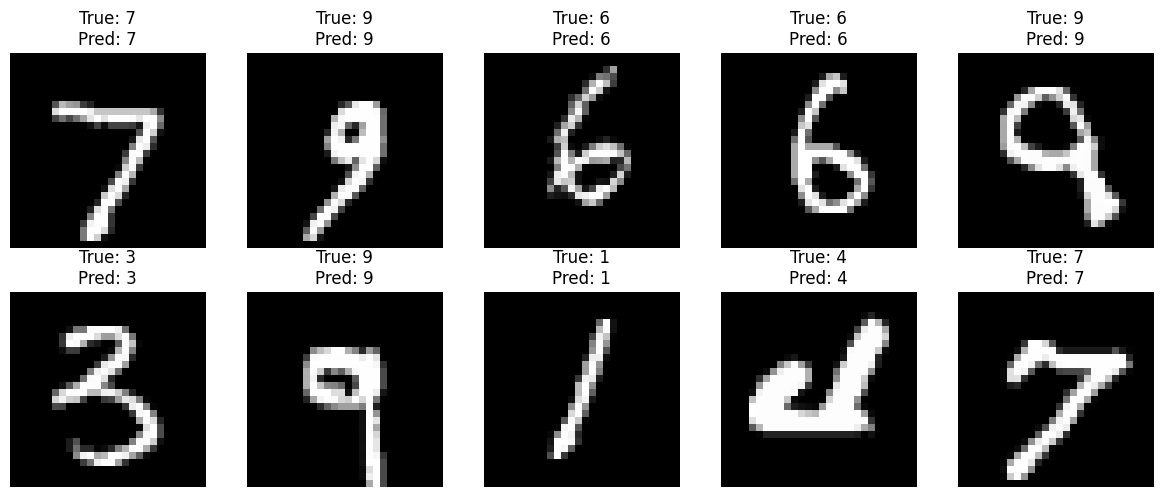

In [6]:
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            ax = axes.flat[i]
            ax.imshow(data[0].cpu().squeeze(), cmap='gray')
            ax.set_title(f'True: {target[0].item()}\nPred: {predicted[0].item()}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/plots/model_predictions.png')
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_loader)